# Final project for Project 2 in IN-STK5000
## Alva Hørlyk, Tobias Opsahl and Ece Cetinoglu

This notebook is contains what will be the final version of Project 2. Since we have changed a bit under the way, the parts for the 1st and 2nd deadline is a bit different, and we therefore deliver the whole project in this notebook. We go through the exercises starting on the 1st deadline, and ending on the last one. 

# General information

First of all, let us introduce our policy. We will look at treaments, and not vaccines.

## Utility
To calculate the utility, we look at each person, their symptoms, treaments and outcomes. For each person we calculate the reward, and the utility is simply the sum of the rewards. The reward is calculated by looking at each symptom. 
If the symptom was there prior to the treatment given, and not afterwards, a positive weight is added. If the symptom was not there before the treatment, but was there afterwards, a negative weight is added, times a penalty. Finally, if any treatment was used (it is not the case that no treatments where used), a treatment-cost is subtracted from the reward.

## Policy overview

We will provide a short overview of the policy here. The actual code should be pretty well documented, so you can find more details in the doc-strings. 

The policy takes the amount of treatments as an argument in the **constructor**, which we assume to be 3 for compatibility with the **simulator.py**. The method **observe()** takes in a poluation (features), actions and outcomes, and fit the models used to predict the outcomes. Note that one would need the population, the actions and the outcomes from treating the poluation with the actions (by using **population.treat()**), before calling the method, since they are required as arguments. To chose the actions for the initial call, one can use **initialize_data()**, to pick actions randomly, and getting the corresponding outcomes. For each treatment, for each symptom, we fit a logistic regression model. Given a treatment and a symtpom, the model takes in some columns from the features as input, and returns the probability for that symptom to be present after the given treatment. 
The method **feature_select()** will chose the columns we want to fit the model on. This is the given symptom, age, income, gender, and the comorbidities. We do not select the other symptoms, because we assume they are not realated. We do not use the genes, becuase after our analysis they seem to be unrealated to the response, and adds a lot of noise.
**get_reward()** calculates the individual reward for each person in features, and **get_utility()** is the sum of the rewards. This was explained in the introductions and there are more details in the code. 
**get_action()** will chose a suitable treatment for each person in features. Note that **observe()** should have been called first. We use the fitted models to predict the probability of symptoms after a treatment, for each treatment. We then use the probability for symptoms as a response to **get_reward()**, to calculate the expected reward. For each person, we chose the treatment with the highest expected reward. If all of the treatments gives negative expected rewards, we chose no treatment. 

The help functions **add_feature_names()**, **add_action_names()** and **add_outcome_names()** sumply converts features, actions and outcomes to a pandas dataframe, with suitable column-names. 

**treatments_given()** checks how many persons recieved at least one treatment. 

We also make a class **ZeroModel**, to only predict zero if the response is only zero. This is because **LogisticRegression** does not work when all of the responses are zero.

Let's do the imports. Note that we renamed aux.py to aux_file.py to work on windows.

In [6]:
import numpy as np
import pandas as pd
from aux_file import symptom_names
import simulator
from IPython import embed
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

Finally, let's look at the actual code for the policy. We also include the RandomPolicy, since it is used in the initialization of the data.

In [7]:
class Policy:
    def __init__(self, n_actions, action_set, threshold=0.5):
        """ 
        In:
            n_actions (int): the number of actions
            action_set (list): the set of actions
            threshold (float): Threshold for caterogizing from logistic regression
        """
        self.n_actions = n_actions
        self.action_set = action_set
        self.threshold = threshold
    
    def initialize_data(self, n_population):
        """
        This function should be called before using the rest of the methods.
        This function simply makes a RandomPolicy of the same length as the
        population will be. This data is then used to fit the models later. 
        In: 
            n_population (int): Size of population, the amount of persons.
        Out:
            features (np.array): The population, generated by simulator.py.
            actions (np.array): The actions chosen by RandomPolicy on features.
            outcomes (np.array): The outcomes when features are treated with actions.
        These are also stored as class variables. 
        """
        population = simulator.Population(128, 3, 3)
        treatment_policy = RandomPolicy(3, list(range(3))) 
        self.n_population = n_population
        self.features = population.generate(self.n_population)
        self.actions = treatment_policy.get_action(self.features)
        self.outcomes = population.treat(list(range(n_population)), self.actions)
        return self.features, self.actions, self.outcomes
    
    def feature_select(self, X, symptom_index=1):
        """
        Chooses some columns in X.
        0 Covid-Recovered
        1 Covid-Positive
        2 No-Taste/Smell
        3 Fever
        4 Headache
        5 Pneumonia
        6 Stomach
        7 Myocarditis
        8 Blood-Clots
        9 Death
        10 Age
        11 Gender
        12 Income
        141 Asthma
        142 Obesity
        143 Smoking
        144 Diabetes
        145 Heart disease
        146 Hypertension
        """
        N = X[:, [symptom_index, 10, 11, 12, 141, 142, 143, 144, 143, 144, 145, 146]]
        return N
        
    def get_reward(self, features, actions, outcome, penalty=1.5, treatment_cost=0.1):
        """
        This method calculates the reward, which in a way is the utility of 
        a single indidual, for each row in the arguments.
        We calculate this by the following:
            For each person, if that person experience some symptom before the,
        treatment, but not after, a positive weight is added to the reward. If
        they did not experience any symptoms before, but do after the action, 
        then a negative weight is added, times a penalty (so new sick 
        individuals can be punished harder than curing sick persons is rewarded).
        The weight corresponds to the severity of the symptoms. 
        Finally, if we apply any action at all, a treatment_cost is subtracted, 
        representing the cost of a treatment. 
        
        In:
            features (np.array): The population.
            actions (np.array): The actions.
            outcome (np.array): The outcome when population is treated with outcome.
            penalty (float): How much worse it is to give a new symptom, than 
                to cure one. If 0, the reward overlooks if a person gets a new
                symptom. When penalty -> \infty, the reward only prevents new
                symptoms, and do not care about the cured patients.
            treatment_cost (float): The cost of a treatment. If one of the 
                columns in actions is non-zero, treatment_cost is subtracted
                from the reward. If not, then no treatment is used, and 
                we do not subtract it. 
        Out:
            rewards (np.array): Array of rewards, corresponding to the persons
                in features (and actions and outcome).
                
        """
        rewards = np.zeros(len(outcome))
        weights = [0, 0.2, 0.1, 0.1, 0.1, 0.5, 0.2, 0.5, 1.0, 100.0]
        threshold = self.threshold
        for t in range(len(features)):
            utility = 0
            for i in range(1, len(weights)): # i loops over the sypmtom indecies
                if features[t, i] == 1 and outcome[t, i-1] < threshold:
                    utility += weights[i]
                if features[t, i] == 0 and outcome[t, i-1] >= threshold:
                    utility -= weights[i] * penalty
            if (np.sum(actions[t, :]) > 0): # Some action were used
                utility = utility - treatment_cost # The treatment is not free
            rewards[t] = utility 
        return rewards
        
    def observe(self, features, actions, outcomes):
        """
        This functions takes in a population, the action used on them, and the
        outcome from doing so. Then it will update the model. 
        The model is updated accordingly:
            For each treatment (which should be 3), for each symptoms (which is
        9, Covid-Recovered is overlooked), a logistic regression method is
        fitted. The models are stored as class variable. If all of the responses
        are 0, then a model constantly predicting 0 is used. The models are
        fitted for each action for each symptoms with the features and action
        as input, and the post_symptom (symptom in outcomes) as response. 
        IN OTHER WORDS: Each model predicts wether a certain treatment will 
        for a certain symptom will continue to be there, after the treatment.
            NOTE: To start the method, one could get the inputs by calling
        initialize_data(), to get a random starting point to fit the data on.
        
        In: 
            features (t*|X| array): The population
            actions (t*|A| array): The actions the population is treated with
            outcomes (t*|Y| array): The outcomes from treating the population
                with the actions.
        """
        self.features = features
        self.actions = actions
        self.outcomes = outcomes
        symptom_indecies = [1, 2, 3, 4, 5, 6, 7, 8, 9] # Indecies for symptoms
        models = []
        for treatment in range(self.n_actions): # for each treatment i
            indecies = self.actions[:, treatment] == 1 # treament i is used
            for symptom_index in symptom_indecies: # for each symptom
                feat = self.features[indecies]
                out = self.outcomes[indecies]
                x_data = self.feature_select(feat, symptom_index)
                y_data = out[:, symptom_index]
                logistic_model = LogisticRegression()
                scaler = preprocessing.StandardScaler().fit(x_data)
                x_scaled = scaler.transform(x_data)
                if sum(y_data) != 0: 
                    logistic_model.fit(x_scaled, y_data)
                    # model = logistic_model.fit(x_scaled, y_data)
                else: # If all y_data is 0, we just predict 0. LogisticRegression would crash
                    logistic_model = ZeroModel("Name")
                models.append(logistic_model)
        self.models1 = models[:9] # Treatments / n_actions should be 3
        self.models2 = models[9:18]
        self.models3 = models[18:]
        
    def get_utility(self, features, actions, outcome, penalty=1.5, treatment_cost=0.1):
        """ 
        Return the empirical utility for a population. This is defined by the
        sum of the rewards, so se Policy.get_reward() for explaination of how
        we define our utility.
        
        Args:
            features (t*|X| array)
            actions (t*|A| array)
            outcomes (t*|Y| array)
            penalty (float): penalty for introducing new symptoms.
            treatment_cost (float): Cost for using a treatment
        Out:
            utility (float): Empirical utility of the policy on this data.
        """
        utility = sum(self.get_reward(features, actions, outcome, penalty, treatment_cost))
        return utility
        
    def get_action(self, features):
        """
        Get actions for one or more people. observe() should already have been
        called, so the model is fitted. 
        The actions are chosen as follows:
            For each person in the dataset, we use the models to extimate the 
        probability for a treatment introducing or removing a symptom, for
        each symptom. Then we have a the probability for the post_symptoms, 
        which behaves as the "expected response". For each person, we then
        see which treatment gives the largest expected reward. If all the 
        expected rewards is below zero, we do not treat them, if at least one
        is positive, we chose the one that is largest.
        In: 
            features (t*|X| array): Population to be found an action on
        Out: 
            actions (t*|A| array): Actions chosen
        """
        symptom_indecies = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        post_symptoms1 = np.zeros((len(features), len(symptom_indecies)))
        post_symptoms2 = np.zeros((len(features), len(symptom_indecies)))
        post_symptoms3 = np.zeros((len(features), len(symptom_indecies)))
        
        for symptom_index in symptom_indecies: 
            x_data = self.feature_select(features, symptom_index)
            scaler = preprocessing.StandardScaler().fit(x_data)
            x_scaled = scaler.transform(x_data)
            pred1 = self.models1[symptom_index - 1].predict_proba(x_scaled)[:, 1]
            pred2 = self.models2[symptom_index - 1].predict_proba(x_scaled)[:, 1]
            pred3 = self.models3[symptom_index - 1].predict_proba(x_scaled)[:, 1]
            post_symptoms1[:, symptom_index-1] = pred1
            post_symptoms2[:, symptom_index-1] = pred2
            post_symptoms3[:, symptom_index-1] = pred3
        
        n_population = len(features)
        mock_actions = np.ones((n_population, 3)) # Represent an actions has been done
        rewards1 = self.get_reward(features, mock_actions, post_symptoms1)
        rewards2 = self.get_reward(features, mock_actions, post_symptoms2)
        rewards3 = self.get_reward(features, mock_actions, post_symptoms3)
        
        actions = np.zeros([n_population, self.n_actions]) # Initialize
        expected_utility = 0
        for t in range(n_population):
            # print(f"1: {pred1[t]} 2: {pred2[t]} 3: {pred3[t]}")
            if np.max(np.asarray([rewards1[t], rewards2[t], rewards3[t]])) < 0:
                # All the treatments have expected utility less than zero
                actions[t, 0] = 0 # Do nothing
            # If at least one expected reward is bigger than 0, we chose the biggest
            elif rewards1[t] >= rewards2[t] and rewards1[t] >= rewards3[t]:
                actions[t, 0] = 1
                expected_utility += rewards1[t]
            elif rewards2[t] >= rewards1[t] and rewards2[t] >= rewards3[t]:
                actions[t, 1] = 1
                expected_utility += rewards2[t]
            elif rewards3[t] >= rewards1[t] and rewards3[t] >= rewards2[t]:
                actions[t, 2] = 1
                expected_utility += rewards3[t]
        # embed()
        self.expected_utility = expected_utility
        return actions
    
    def get_arguments(self):
        return self.features, self.actions, self.outcomes

class RandomPolicy(Policy):
    """ This is a purely random policy!"""

    def get_utility(self, features, action, outcome):
        """Here the utiliy is defined in terms of the outcomes obtained only, ignoring both the treatment and the previous condition.
        """
        actions = self.get_action(features)
        utility = 0
        utility -= 0.2 * sum(outcome[:,symptom_names['Covid-Positive']])
        utility -= 0.1 * sum(outcome[:,symptom_names['Taste']])
        utility -= 0.1 * sum(outcome[:,symptom_names['Fever']])
        utility -= 0.1 * sum(outcome[:,symptom_names['Headache']])
        utility -= 0.5 * sum(outcome[:,symptom_names['Pneumonia']])
        utility -= 0.2 * sum(outcome[:,symptom_names['Stomach']])
        utility -= 0.5 * sum(outcome[:,symptom_names['Myocarditis']])
        utility -= 1.0 * sum(outcome[:,symptom_names['Blood-Clots']])
        utility -= 100.0 * sum(outcome[:,symptom_names['Death']])
        return utility
    
    def get_action(self, features):
        """Get a completely random set of actions, but only one for each individual.
        If there is more than one individual, feature has dimensions t*x matrix, otherwise it is an x-size array.
        
        It assumes a finite set of actions.
        Returns:
        A t*|A| array of actions
        """

        n_people = features.shape[0]
        ##print("Acting for ", n_people, "people");
        actions = np.zeros([n_people, self.n_actions])
        for t in range(features.shape[0]):
            action = np.random.choice(self.action_set)
            if (action >= 0):
                actions[t,action] = 1
            
        return actions

Here are the help functions:

In [8]:
def add_feature_names(X):
    """
    Convert a population / features / X to a pandas dataframe with suitable names.
    """
    features_data = pd.DataFrame(X)
    features = []
    features += ["Covid-Recovered", "Covid-Positive", "No-Taste/Smell", "Fever", 
                 "Headache", "Pneumonia", "Stomach", "Myocarditis", 
                 "Blood-Clots", "Death"]
    features += ["Age", "Gender", "Income"]
    features += ["Genome" + str(i) for i in range(1, 129)]
    features += ["Asthma", "Obesity", "Smoking", "Diabetes", 
                 "Heart disease", "Hypertension"]
    features += ["Vaccination status" + str(i) for i in range(1, 4)]
    features_data.columns = features
    return features_data
    
def add_action_names(actions):
    """
    Convert np.array of actions to a pandas dataframe with suitable names.
    """
    df = pd.DataFrame(actions)
    names = ["Treatment" + str(i) for i in range(1, actions.shape[1] + 1)]
    df.columns = names
    return df

def add_outcome_names(outcomes):
    """
    Convert a np.array of outcomes / post_symptoms to a pandas dataframe with
    suitable names. 
    """
    df = pd.DataFrame(outcomes)
    columns = ["Covid-Recovered", "Covid-Positive", "No-Taste/Smell", "Fever", 
                  "Headache", "Pneumonia", "Stomach", "Myocarditis", 
                  "Blood-Clots", "Death"]
    for i in range(len(columns)):
        columns[i] = "Post_" + columns[i]
    df.columns = columns
    return df

def treatments_given(actions):
    """
    Given a set of actions, this function will return how many the patient who
    recieved at least one action, in other words, do not have 0 for every
    action column.
    """
    actions = np.asmatrix(actions)
    s = 0
    for i in range(len(actions)):
        if np.sum(actions[i, :]) > 0:
            s += 1
    return s

class ZeroModel:
    """
    This class is simply made for always prediction 0. LogisticRegression
    does not work for only 0 inputs in the response, so we do this instead.
    """
    def __init__(self, name="name"):
        self.name = name
    
    def predict(self, array):
        """
        0 or 1 predictions, which should always be 0.
        """
        return np.zeros(len(array))
    
    def predict_proba(self, array):
        """
        Probability predictions for "yes" and "no" for each input, 0 and 1.
        """
        prob = np.zeros((len(array), 2))
        prob[:, 1] = np.ones(len(array))
        return prob

# 1st Deadline

We will now explore ways to add privacy to the data and the models

## a)
One simple way to protect the private information of the individuals is to just hide direct identifiers. However this is generally insufficient as attackers may have other identifying information. This information, combined with the information in the database, can reveal identities. 
<br>
Another method is k-anonymization, where k-1 people are indistinguishable from each other (with respect to quasi-identifiers) in the database. Columns with personal information, like name and date of birth are removed, and the rest of the information is generalized. For instance can a variable like age be categorical with different age-groups. Even though k-anonymization is an improvement from simply removing direct identifiers, an attacker with enough imformation can still infer something about the individuals.
<br>
If we assume that an attacker can have a lot of side-information, it is better to use differential privacy. For instance, we can use the Laplace mechanism, where Laplace distributed noise is added in the model. How much noise we add determines how private the result is. We can randomly chose a fraction of the data and add noise to it. This way, even if the data was publicly available, one would not be certain if the it really was true. The goal would obviously add a fraction of noise that makes the data private enough, but do not lower the predictions significantly. 
<br>
In this task the policy is released and can be used by the public. Then the data have to be anonymized before $\pi(a|x)$ is obtained. This can be done using a local privacy model, where independent Laplace noise $\omega_{i}$ is added to each individual. We have $y_{i}=x_{i}+\omega_{i}$ and use it to get $a=n^{-1}\sum_{i=1}^{n}y_{i}$.

## b) 
Here we assume that the analysts can be trusted with private information, so only the result made available for the public have to be privatized. Then we can use a centralized privacy model. We obtain $\pi(a|x)$ with $a=n^{-1}\sum_{i=1}^{n}x_{i}+\omega$. We do not need to privatize the data, just a bit of the decisions of the model we fitted on it. 

In other words, we can add noise to the actions after fitting the model. Without changing any of the observations in the population, we can fit a model that decides actions, and then add a bit of noise to the actions. This is so it one could not figure out personal data based on the action we chose, which might happen if the model picks ups a simple pattern in the data. 

For the actual implementation, we use both approaches. First, we add noise to the data itself and fit a model. Then we try to fit a model first, then add noise to the results. 
For the first approach, we implement functions for adding noise to our data. For the binary data, the function randomize() choses a ratio "1-theta" from a column, and changes it with a coinflip (50-50 chance of 0 and 1). For the continious variables, we replace the coinflip with the same data pluss an addition drawn from the Laplace distribution.

We then loop over all the desired columns in our population and add noise one by one. The desired columns are the Symptoms,  Age, Income, Gender and the co-morbidities. We were not sure wether or not to add symptoms. By calculation the utility with the privatized X and the actions that was got from them, it would drasticly change the utility. For example, let's say that our noise happend add a lot of symptoms. Then this would artificially make our model look way better than it actually would be, since they would be, since it would look like it removed a lot of positive cases. The utility is calculated directly on the pre-symptom, action and post-symptom, so we did not want to add noise here. However, if we would send in a non-privatized X, and the actions found on the privatized X, one would need to original data to calculate the utility, and that would require a lot of information loss. Therefore, we preffered not to add noise to the symptoms. 

For the second approach, we simply fit the model on the data, then sends the outcome columns to the functions to add noise. We will do this two ways. First, we simply shuffle a persons actions with a "1-theta" probability. This may change the treatment a treated person is given, but it will not change a non-treated person, since all of their action-columns will correspond to 0. Therefore, we secondly draw 1, 2, 3 or no-treatment, with a 1-theta probability, for each person. 

## c) 

Here is the implementation of the methods explained above. 

In [9]:
def privatize_actions_shuffle(A, theta):
    """
    Adds noise to the actions chosen by the model. This is done by shuffling 
    the actions given to each person, with a probability 1 - theta. 
    """
    A1 = A.copy()
    coins = np.random.choice([True, False], p=(theta, (1-theta)), size=A.shape[0])
    for i in range(A1.shape[0]):
        if not coins[i]:
            np.random.shuffle(A1[i, :])
    return A1

def privatize_actions_draw(A, theta):
    """
    Adds noise to the actions chosen by the model. This is done by choicing a 
    new action with a probability 1-theta.
    """
    A1 = A.copy()
    coins = np.random.choice([True, False], p=(theta, (1-theta)), size=A.shape[0])
    for i in range(A1.shape[0]):
        if not coins[i]:
            A1[i, :] = np.zeros(A.shape[1])
            coin = np.random.randint(A.shape[1]+1)
            if coin != A.shape[1]:
                A1[i, coin] = 1
    return A1
    
def randomize(a, theta):
    """
    Randomize a single column. Simply add a coin-toss to 1- theta amount of the data
    """
    coins = np.random.choice([True, False], p=(theta, (1-theta)), size=a.size)
    noise = np.random.choice([0, 1], size=a.size)
    response = np.array(a)
    response[~coins] = noise[~coins]
    return response 
    
def randomize_cont(a, theta, decay=1):
    coins = np.random.choice([True, False], p=(theta, (1-theta)), size=a.size)
    noise = np.random.laplace(0, decay, a.size)
    response = np.array(a)
    response[~coins] = response[~coins] + noise[~coins]
    return response
    
def privatize(X, theta):
    """
    Adds noice to the data, column by column. The continious and discreet 
    columns are treated differently. 
    """
    df = add_feature_names(X).copy()
    df["Age"] = randomize_cont(df["Age"], theta)
    df["Income"] = randomize_cont(df["Income"], theta)
    columns = ["Gender", "Asthma", "Obesity", "Smoking", 
               "Diabetes", "Heart disease", "Hypertension"]
    for column in columns:
        df[column] = randomize(df[column], theta)
    # symptoms = ["Covid-Recovered", "Covid-Positive", "No-Taste/Smell", "Fever", 
    #            "Headache", "Pneumonia", "Stomach", "Myocarditis", "Blood-Clots", "Death"]
    # for columns in symptoms: # Shuffle symptoms
    #     df[column] = randomize(df[column], theta)
    return np.asarray(df)

## d)
Now lets test:

In [10]:
np.random.seed(57)
n_genes = 128
n_vaccines = 3
n_treatments = 3
n_population = 10000
population = simulator.Population(n_genes, n_vaccines, n_treatments)
np.random.seed(57)
X = population.generate(n_population) # Population
treatment_policy = Policy(n_treatments, list(range(n_treatments)))
np.random.seed(57)
features, actions, outcomes = treatment_policy.initialize_data(n_population)
treatment_policy.observe(features, actions, outcomes)
A = treatment_policy.get_action(X) # Actions 
U = population.treat(list(range(n_population)), A)

In [11]:
np.random.seed(577)
thetas = [1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
utility_list1 = np.zeros(len(thetas) + 1)
utility_list2 = np.zeros(len(thetas) + 1)
utility_list3 = np.zeros(len(thetas) + 1)
utility_list1[0] = treatment_policy.get_utility(X, A, U)
utility_list2[0] = treatment_policy.get_utility(X, A, U)
utility_list3[0] = treatment_policy.get_utility(X, A, U)
for i in range(len(thetas)):
    np.random.seed(57)
    X_noise = privatize(X, thetas[i])
    A_noise1 = treatment_policy.get_action(X_noise)
    A_noise2 = privatize_actions_shuffle(A, thetas[i])
    A_noise3 = privatize_actions_draw(A, thetas[i])

    U1 = population.treat(list(range(n_population)), A_noise1)
    U2 = population.treat(list(range(n_population)), A_noise2)
    U3 = population.treat(list(range(n_population)), A_noise3)

    utility_list1[i+1] = treatment_policy.get_utility(X_noise, A_noise1, U1)
    utility_list2[i+1] = treatment_policy.get_utility(X, A_noise2, U2)
    utility_list3[i+1] = treatment_policy.get_utility(X, A_noise3, U3)


In [12]:
utility_list1

array([2311.7 , 1535.55,  413.55, 1758.8 , 1189.25, 1502.3 , 1753.05,
       2057.95, 1804.05, 1608.3 , 2109.5 , 2656.15, 2883.8 , 2684.1 ])

In [13]:
utility_list2

array([ 2311.7 ,  1645.35,  1383.55,  1642.  ,  1078.05,  1522.6 ,
         565.15,   752.9 ,   656.55,   841.9 ,   -66.35, -1949.85,
        -507.65, -1446.85])

In [14]:
utility_list3

array([ 2311.7 ,  2409.5 ,  1089.7 ,  1688.8 ,  1917.8 ,   993.45,
         304.7 ,  -900.2 ,  -688.3 , -2214.7 , -1681.25, -2023.1 ,
       -4246.65, -5119.2 ])

First of all, there is a lot of noise. If one tries to run again with different seeds, one would see that the results highly varies. However, there is a definite downwards trend proportional to the increase of noise for the last two lists. These are the list that corresponds to shuffling and making new draws for the actions. This means that our model is working better than assigning random actions, but that we can not add too much privacy if we want to keep the utility high.

Note that or model only works with a lot of data. The response for a lot of the symptoms are rare, and we think there is a lot of noise in the data, so our logistic regression model needs some thousands of observation to actually get a positive utility. Therefore, finding the optimal theta parameter is hard. There is much noise in the utility calculated, wo we have to run the test many times and look at the standard deviation.

However, the data that privatized the data prior to finding the actions performed a lot better. Even though it varied a lot, it the complete randomization (with theta = 0) had a higher utility than for no privacy (theta = 1). We do find this a bit strange, but it does make sence. Since the actions are fitted on the *privatized data*, the actions match the data with respect to the symptoms, since we did not randomize these. The sensitive variables may be a lot of noise. For the privitazed data, we first fitted the actions on the original population, then privatized the results. We think that the logistic regression model might adapt to the randomization in X better than shuffling the predictions. Either way, privatizing X also allows for better privacy, since then we do not leak information when we update our actions, and we do not need our original X for calculating the utility. Therefore, we prefer the method of adding the noice to the data of the patients. 

# 2nd deadline

# Fair Policies

We would like to investigate the fairness of our decision-making algorithm. When we are deciding the treatment method for each individual in our population, we want to make sure that the decision is made fairly and we are just to the individuals. The sensitive variables in our data set are `Age`, `Income` and `Gender`. We want ensure that the sensitive variables do not affect the treatment given to the individuals, such that $\mathbb{P}^{\pi}_{\theta}(a|z) = \mathbb{P}^{\pi}_{\theta}(a)$ for all actions $a$ and sensitive variables $z$.

For example, if we have more men than women in our population, the decision-making algorithm will be adapted to men.

We will now analyze the population and look at some numbers and graphs. We will start by generating data and preprocessing. We remove the columns corresponding to genes, and we add the action columns which corresponds to the treatment chosen for each individual.

In [15]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Generate data
np.random.seed(57)
n_genes = 128
n_vaccines = 3
n_treatments = 3
n_population = 10000
population = simulator.Population(n_genes, n_vaccines, n_treatments)
treatment_policy = Policy(n_treatments, list(range(n_treatments)))
X = population.generate(n_population)
features, actions, outcomes = treatment_policy.initialize_data(n_population)
treatment_policy.observe(features, actions, outcomes)
df_X = add_feature_names(X)

In [17]:
# Remove genes
# temp1 = df_X.iloc[:, :13] 
# temp2 = df_X.iloc[:, -9:]
# features = temp1.join(temp2)
features = df_X
np.random.seed(57)
A = treatment_policy.get_action(X)
actions = pd.DataFrame(A)
actions.columns = ["Treatment1", "Treatment2", "Treatment3"]
features = features.join(actions)
# Create a single Treatment column for easier data visualizing 
#treat = np.zeros(features.shape[0])
#features["Treatment"] = treat
features.loc[features.Treatment1 == 1.0, "Treatment"] = "1"
features.loc[features.Treatment2 == 1.0, "Treatment"] = "2"
features.loc[features.Treatment3 == 1.0, "Treatment"] = "3"
features["Treatment"] = features["Treatment"].fillna("0")
#features["Income"]

## Gender

We will first investigate `Gender`. We assume that `Gender` is `0.0` for men and `1.0` for women.

In [18]:
# Gender
women_nr = features[features.Gender == 1.0].shape[0]
men_nr = features[features.Gender == 0.0].shape[0]
g1 = features.groupby(by="Gender")["Treatment1"].value_counts(normalize=True)
g2 = features.groupby(by="Gender")["Treatment2"].value_counts(normalize=True)
g3 = features.groupby(by="Gender")["Treatment3"].value_counts(normalize=True)

In [19]:
g1, g2, g3 # Vet ikke om det er nødvendig

(Gender  Treatment1
 0.0     0.0           0.849749
         1.0           0.150251
 1.0     0.0           0.850847
         1.0           0.149153
 Name: Treatment1, dtype: float64,
 Gender  Treatment2
 0.0     0.0           0.976931
         1.0           0.023069
 1.0     0.0           0.981456
         1.0           0.018544
 Name: Treatment2, dtype: float64,
 Gender  Treatment3
 0.0     0.0           0.996189
         1.0           0.003811
 1.0     0.0           0.995414
         1.0           0.004586
 Name: Treatment3, dtype: float64)

In [20]:
print(f"Number of women: {women_nr}")
print(f"Number of men: {men_nr}")

Number of women: 5015
Number of men: 4985


We almost have equal amount of men and women in our population. We now check which treatment each gender has gotten:

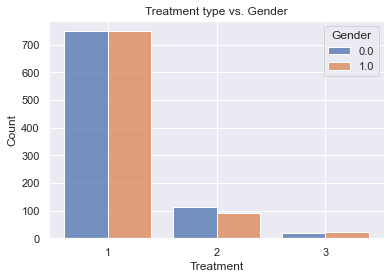

In [21]:
sns.set_theme()
indicies = features["Treatment"] != "0"
sns.histplot(data = features[indicies].sort_values(by="Treatment"), x = "Treatment", hue = "Gender", multiple="dodge", shrink=.8)
plt.title("Treatment type vs. Gender")
plt.show()

We observe that the treatments are almost equally distributed amongst genders, i.e there are (almost) equal amount of men and women who recieved Treatment 1, 2 or 3. However, we also observe that most of the population gets Treatment 1. We see that there are fewer women who have received Treatment 2 than men who have received Treatment 2, but the difference is not so big. We also see that there are the number of women who received Treatment 3 is greater than the number of men who received Treatment 3. Based on the graph and the numbers, the data seems to be almost unbiased for `Gender`.

## Income

We categorize the individuals by their income. We now have two income categories: low and high income. Every individual with an income less than the median income for the entire population are categorized as `Low income`, and every individual with an income greater than the median income is categorized as `High income`. We would like to see which treatment is frequently given to individuals with low and high income.

In [22]:
# Income
median = features.Income.median()
income = features.Income.values.astype(float)
features.loc[income < median, "Income category"] = "Low income"
features.loc[income >= median, "Income category"] = "High income"

i1 = features.groupby(by="Income category")["Treatment1"].value_counts(normalize=True)
i2 = features.groupby(by="Income category")["Treatment2"].value_counts(normalize=True)
i3 = features.groupby(by="Income category")["Treatment3"].value_counts(normalize=True)

In [23]:
i1, i2, i3

(Income category  Treatment1
 High income      0.0           0.8450
                  1.0           0.1550
 Low income       0.0           0.8556
                  1.0           0.1444
 Name: Treatment1, dtype: float64,
 Income category  Treatment2
 High income      0.0           0.9798
                  1.0           0.0202
 Low income       0.0           0.9786
                  1.0           0.0214
 Name: Treatment2, dtype: float64,
 Income category  Treatment3
 High income      0.0           0.9968
                  1.0           0.0032
 Low income       0.0           0.9948
                  1.0           0.0052
 Name: Treatment3, dtype: float64)

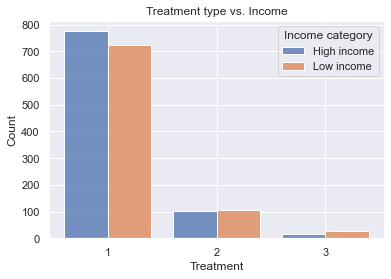

In [24]:
#sns.set_theme()
sns.histplot(data = features[indicies].sort_values(by="Treatment"), x = "Treatment", hue = "Income category", multiple="dodge", shrink=.8)
plt.title("Treatment type vs. Income")
plt.show()

Once again, we observe that the different types of treatments are (almost) equally distributed amongst people with different levels of Income. We see that the population have mostly received Treatment 1. However, the number of people with high income who received Treatment 1 is greater than the number of people with low income who got the same Treatment. Similarly, there are more people with low income who received Treatment 2 and 3 than people with high income. Overall, there is little bias for `Income`.

## Age

We categorize the individuals by their age. We first tried to create five uniformly spaced age categories. However, this did not work very well, since the column `Age` has Gamma distribution and we have more young people than old people.

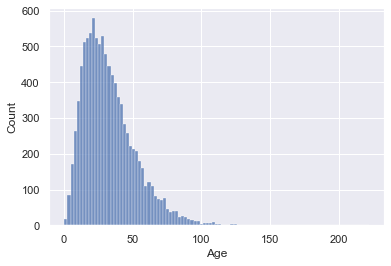

In [25]:
# Plot showing the age frequencies
sns.histplot(data = features, x = "Age")
plt.show()

In [26]:
age_limits = np.linspace(features.Age.min(), features.Age.max(), 6, dtype=int)
age_category = pd.DataFrame(pd.cut(features.Age, bins=age_limits,
                                   labels=["Age<24","24<=Age<47", "47<=Age<71", "71<=Age<94", "Age>94"],
                                   include_lowest=True, ordered=True))

age_category.columns = ["age_category"]
features = features.join(age_category)

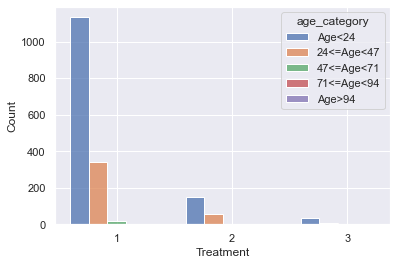

In [27]:
# Plot showing the age frequencies with 5 age categories
sns.histplot(data = features[indicies].sort_values(by="Treatment"), x = "Treatment", hue = "age_category", multiple="dodge", shrink=0.8)
plt.show()

We then decided to have two age categories: young and old. Every individual with an age smaller than the median age for the entire population are categorized as `Young`, and every individual with an age bigger than the median age is categorized as `Old`. We would like to see which treatment is frequently given to young and old individuals.

In [28]:
features.drop("age_category", axis=1, inplace=True)
median_age = features.Age.median()
features.loc[features.Age.values < median_age, "age_category"] = "Young"
features.loc[features.Age.values >= median_age, "age_category"] = "Old"

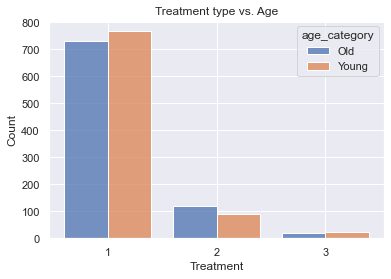

In [29]:
sns.histplot(data = features[indicies].sort_values(by="Treatment"), x = "Treatment", hue = "age_category", multiple="dodge", shrink=0.8)
plt.title("Treatment type vs. Age")
plt.show()

Once again, we observe that the different types of treatments are (almost) equally distributed amongst people with different levels of Age. The number of young people who received Treatment 1 og 3 is slightly higher than the number of people who received the same treatments.

Overall, the data is quite unbiased on the sensitive variables `Gender`, `Income` and `Age`.

## Quantifiyng fairness

### P-scores

Now let us try quantify the fairness in our policy. We first do this with a comparrison of outcome, with p-scores. P-scores are defined by $\text{p-score} = \min \left(\frac{P(\hat{y} = 1| z = 1)}{P(\hat{y} = 1 | z = 0)}, \frac{P(\hat{y} = 1| z = 0)}{P(\hat{y} = 1 | z = 1)}\right)$. Here $\hat{y}$ is our expected outcome, the treatment we give (including no treatment), and $z$ is the sensitive data, put in two grups. With the $\min$ function, we chose the one that is less or equal to 1. However, we drop the $\min$ function, so that we can see which group corresponded to having more or less treatments. We can interpret this score as equality of outcome. If it is far from 0, it means that we have treat the $z$ group have different outcomes, meaning that they get different treatments. 

Our sensitive variables are ones again Gender, Age and Income. For gender, the dichotimization is obvious, $z=1$ corresponds to one gender and $z=0$ to the other. For age and income, we must split in two groups. Since the data is not uniformly distributed, we split the data at the median, to get two different groups, below and above the median. 

Let's calculate the p-scores. We do this for all of the tree variables, for all of the three treatments, including no treatment. The $\hat{y} = 1$ is therefore "got treatment1", "got treatment2", "got greatment3" and "did not recieve any treatment", respectivly in the loop.

In [30]:
np.random.seed(57)
n_genes = 128
n_vaccines = 3
n_treatments = 3
n_population = 10000
population = simulator.Population(n_genes, n_vaccines, n_treatments)
np.random.seed(57)
X = population.generate(n_population) # Population
# embed()
treatment_policy = Policy(n_treatments, list(range(n_treatments)))
np.random.seed(57)
features, actions, outcomes = treatment_policy.initialize_data(n_population)
treatment_policy.observe(features, actions, outcomes)
# features, actions, outcomes = treatment_policy.get_arguments()

A = treatment_policy.get_action(X) # Actions 
U = population.treat(list(range(n_population)), A)

In [31]:
df1 = add_feature_names(X)
df2 = add_action_names(A)
df3 = add_outcome_names(U)
df = df1.join(df2.join(df3))
gender = df["Gender"] > df["Gender"].median()
income = df["Income"] > df["Income"].median()
age = df["Age"] > df["Age"].median()
variables = [gender, income, age]
treatments = ["Treatment1", "Treatment2", "Treatment3"]
p_scores = np.zeros((3, 4)) # Treat1, 2, 3, no_treatment
for i in range(len(treatments)): # Treatment 1, 2 and 3
    treatment = treatments[i]
    for j in range(len(variables)):
        variable = variables[j]
        p_score = df[variable][treatment].mean() / df[~variable][treatment].mean()
        p_scores[j, i] = p_score
for j in range(len(variables)): # No treatment
    variable = variables[j]
    group1 = df[variable][(df[variable]["Treatment1"] == 0.0) & 
                          (df[variable]["Treatment2"] == 0.0) & 
                          (df[variable]["Treatment3"] == 0.0)]
    group2 = df[~variable][(df[~variable]["Treatment1"] == 0.0) & 
                           (df[~variable]["Treatment2"] == 0.0) & 
                           (df[~variable]["Treatment3"] == 0.0)]
    p_score = len(group1) / len(group2)
    p_scores[j, 3] = p_score

print(p_scores) # Age is the least equal one

[[0.939621   1.82644939 1.12487528 1.00486145]
 [1.02064516 1.18181818 0.91666667 0.99661099]
 [1.00255754 1.08695652 1.3        0.99467956]]


As we see, the p_values are pretty close to 1. Therefore, we decide that our policy is pretty fair. If we would have traded fairness for utility, we would first look at which variable are "discriminated agianst". For example, let say far less females gets assigned a treatment than males. To adjust for this, we could set the threshold for females to get a positive and negative reward could be set to higher or lower. The reward function looks at how likely a sick person is to get cured, and opositite. The logistic regression returns a probability for wether a sick person will get cured. If this probability is below 0.5, we assume that it predicts that the person will be cured, and assign them a positive reward. The reward is later used for assigning treatments. We choose the treatment that is corresponding to the highest reward. If we were to set the threshold for the probability for women to for example 0.7, then more women would be considered cured, and they would get more treatments. This would balance the fairness. This threshold parameter could then be balanced against the total utility in some algorithm. 

### Equal opportunity score

We will now try to meassure fairness anotherway, by equal opportunity scores. This is defined by $\text{equal-opportunity-score} = \min \left(\frac{P(\hat{y} = 1| z = 1, y = 1)}{P(\hat{y} = 1 | z = 0, y = 1)}, \frac{P(\hat{y} = 1| z = 0, y = 1)}{P(\hat{y} = 1 | z = 1, y = 1)}\right)$. Here $\hat{y}$ and $z$ is the same, the prediction and the sensitive group. We also have $y$, which is the true outcome. If we look at our model for predicting post-symptoms, $\hat{y}=1$ would correspond to our model predicting there will be no symptom and $y=1$ would correspond to actually not getting the symptom (we chose $y=1$ to *not* having the symptom over actually having it, because this is more closely related to getting chosen for a treatment). We therefore can not meassure the action, like in the last paragraph, since we need to know the true outcome. We also have to have an action as *given*. As with the last part, we do not use the $min$ function. We want to calculate $\frac{P(\hat{y} = 1| z_i = 1, y = 1, a_i = 1)}{P(\hat{y} = 1 | z_i = 0, y = 1, a_i = 1)}$, in other words: What is the difference in probability for a sensitive group $z$ for predicting a post-symtpom for a given action and given that they actually did not get the symptom after the action?

When we implement this, we define a function for calculates it for each model. That means, for each sensitive variable, for each treatment, for each symptom, we get a number. That is rather elaborate, but we also have the choice of summing up treatments and symptoms in each sensitive group before dividing. Here is the code (sorry for the nesting):

In [36]:
def equal_opportunity_scores(features, actions, outcomes, model_list):
    """
    Returns the equal opportunity scores. This is defined by the probability
    of predicting that an individual will not be sick. The models should be
    fitted in advance, with observe(). Note that we care about _not_ being sick,
    because this is closely related to actually being treated. 
    
    This return two two-dimensonal array for each of the sensitive 
    variables. The two arrays responds to group 1 and group 2 of the
    sensitive variables (for example over median income and under). The
    arrays are shape 3 x 9. The three rows corresponds to the treatments.
    The 9 columns corresponds to the 9 symptoms. For every time a person 
    with an action i does not have a symptom j and the models predict 
    they will not have the symptom j, the corresponding array gets += 1 in
    the [i, j]th place. The equal opportunity scores are then obtained by
    dividing the arrays. One can also sum the rows or columns if one does
    not care about the individual treatments or symptoms, respectivly, 
    before dividing.
    """
    df = add_feature_names(features) # for easy calculation and debugging
    treatments = ["Treatment1", "Treatment2", "Treatment3"]
    symptom_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    treat1_indices = actions[:, 0] == 1 # Have gotten treatment1
    treat2_indices = actions[:, 1] == 1 # Have gotten treatment2
    treat3_indices = actions[:, 2] == 1 # Have gotten treatment3
    indices_list = [treat1_indices, treat2_indices, treat3_indices]
    # model_list = [self.models1, self.models2, self.models3]
    
    equal_scores_g1 = np.zeros((3, 9)) # gender = 1
    equal_scores_g2 = np.zeros((3, 9)) # gender = 0
    equal_scores_i1 = np.zeros((3, 9)) # income >= income.median()
    equal_scores_i2 = np.zeros((3, 9)) # income < income.median()
    equal_scores_a1 = np.zeros((3, 9)) # age >= age.median()
    equal_scores_a2 = np.zeros((3, 9)) # age < age.median()
    for i in range(3): # Loop over the treatments and corresponding models
        indicies = indices_list[i]
        data = features[indicies]
        out = outcomes[indicies]
        models = model_list[i]
        for j in symptom_indices: # Loop over symptoms (j is 1 over range(9))
            # feature select:
            x_data = data[:, [j, 10, 11, 12, 141, 142, 143, 144, 143, 144, 145, 146]]
            scaler = preprocessing.StandardScaler().fit(x_data)
            x_scaled = scaler.transform(x_data)
            pred = models[j-1].predict_proba(x_scaled)[:, 1] # Predict
            pred_positives = pred < 0.5 # We predict: No symptom
            out_positives = out[:, j] == 0 # The truth is: No symptom
            for t in range(len(pred)):
                if pred_positives[t] and out_positives[t]:
                    if data[t, 10] >= df["Age"].median():
                        equal_scores_a1[i, j-1] += 1 
                    else:
                        equal_scores_a2[i, j-1] += 1
                    if data[t, 12] >= df["Income"].median():
                        equal_scores_i1[i, j-1] += 1 
                    else:
                        equal_scores_i2[i, j-1] += 1
                    if data[t, 11] == 1:
                        equal_scores_g1[i, j-1] += 1 
                    else:
                        equal_scores_g2[i, j-1] += 1           
    # embed()
    return equal_scores_a1, equal_scores_a2, equal_scores_g1, \
           equal_scores_g2, equal_scores_i1, equal_scores_i2

In [37]:
models = [treatment_policy.models1, treatment_policy.models2, treatment_policy.models3]
a1, a2, g1, g2, i1, i2 = equal_opportunity_scores(X, A, U, models)

In [38]:
a2/a1

array([[0.97681159, 0.99871795, 0.98668442, 1.02729885, 0.99872123,
        0.99486521, 0.99872123, 0.99871795, 1.        ],
       [1.2       , 1.0952381 , 1.04545455, 0.8       , 0.92      ,
        0.92      , 0.92      , 1.        , 0.94444444],
       [0.9       , 0.64285714, 0.77027027, 0.76923077, 0.77922078,
        0.76923077, 0.77922078, 0.76315789, 0.75641026]])

In [39]:
g2/g1

array([[1.0358209 , 1.06763926, 1.07222222, 1.07805596, 1.06472919,
        1.072     , 1.06746032, 1.05944518, 1.0660502 ],
       [0.57142857, 0.62962963, 0.5       , 0.60714286, 0.5483871 ,
        0.5483871 , 0.5483871 , 0.53333333, 0.66666667],
       [0.58333333, 0.82539683, 0.92647059, 0.89041096, 0.87671233,
        0.89041096, 0.90277778, 0.91428571, 0.87671233]])

In [40]:
i2/i1

array([[0.9796807 , 0.98094028, 0.9657444 , 0.9679219 , 0.97848101,
        0.97709924, 0.97848101, 0.98094028, 0.97974684],
       [0.375     , 0.83333333, 0.8       , 0.95652174, 0.84615385,
        0.84615385, 0.84615385, 0.76923077, 0.66666667],
       [1.23529412, 1.09090909, 1.11290323, 1.09090909, 1.07575758,
        1.09090909, 1.10769231, 1.09375   , 1.10769231]])

As mentioned, this is pretty elaborate, since we have differentiated with respect to group, treatment and symptom. Also note that some of these groups have a pretty low number of instances, which is why some values are exactly 1 or 0.5. This makes the number variable according to seed, however, they are all pretty close to 1. Let us try to sum first. First, we sum the treatments:

In [41]:
np.sum(a2, axis=0)/np.sum(a1, axis=0)

array([0.97622378, 0.97244546, 0.96930342, 0.99499374, 0.97737557,
       0.97278912, 0.97737557, 0.97838453, 0.97722096])

In [42]:
np.sum(g1, axis=0)/np.sum(g2, axis=0)

array([0.98455056, 0.96567506, 0.96235294, 0.95823096, 0.97068771,
       0.96388262, 0.96625422, 0.97165533, 0.96158192])

In [43]:
np.sum(i2, axis=0)/np.sum(i1, axis=0)

array([0.9789916 , 0.98383372, 0.97163121, 0.97766749, 0.98185941,
       0.98177677, 0.98410897, 0.98289624, 0.98173516])

Here I have divided by a2/a1, then g1/g2 and i2/i1 to make the numbers more readable. Since all of the number are negative, one groups does clearly not have the same opportunity as the other. People with gender = 1, higher income or higher age than the median, have a higher opportunity of getting treated. Let us sum with respect to symptom as well:

In [44]:
np.sum(a2, axis=1)/np.sum(a1, axis=1)

array([0.99780123, 0.95767196, 0.75955414])

In [45]:
np.sum(g1, axis=1)/np.sum(g2, axis=1)

array([0.93896714, 1.76119403, 1.14147287])

In [46]:
np.sum(i2, axis=1)/np.sum(i1, axis=1)

array([0.97664975, 0.80487805, 1.10076046])

Here we do not have so clear results, that is because the first symptom has many more cases than the other. Let us sum the whole arrays:

In [47]:
np.sum(a2)/np.sum(a1)

0.9772221494960074

In [48]:
np.sum(g1)/np.sum(g2)

0.9669227764031775

In [49]:
np.sum(i2)/np.sum(i1)

0.980592709152898

There is one important observation not yet commented; almost all of the score as very close to 1. There were some variablility when we did no summing, but by summing for either treatment or symptom, they are so close to 1 that I would not be worried about the fairness.

Let us try one more thing; a weighted sum. Now the sums are uniform, but in the utility we weight the symptoms. Therefore, we will now try to first sum with respect to treatment, then do a weighted sum with respect to symptom.  

In [50]:
weights = [0.2, 0.1, 0.1, 0.1, 0.5, 0.2, 0.5, 1.0, 100.0]
np.sum((np.sum(a2, axis=0)*weights))/np.sum((np.sum(a1, axis=0)*weights))

0.977227264708917

In [51]:
np.sum((np.sum(g1, axis=0)*weights))/np.sum((np.sum(g2, axis=0)*weights))

0.961789188867876

In [52]:
np.sum((np.sum(i2, axis=0)*weights))/np.sum((np.sum(i1, axis=0)*weights))

0.9817433144257617

Which is still very fair, which could have been predicted by looking at the first dividision with respect to treatment and symptoms, since no value here was *very* far from 1. 

# 3rd Deadline

Firstly, we use some functions for reading and converting the historical data to pandas dataframes with suitable names. Please note that the data-files are (obviously) necessary.

Since *all* of the numbers are negative, this means that each group cleary does not have equal opportunity. Gender = 0, higher income and older people have a higher opportunity of getting treated. Let us sum the symptoms as well:

In [53]:
def init_features(data):
    """
    Initialize names for observation features and treatment features
    
    Symptoms (10 bits): Covid-Recovered, Covid-Positive, No-Taste/Smell, 
        Fever, Headache, Pneumonia, Stomach, Myocarditis, Blood-Clots, Death
    Age (integer)
    Gender (binary)
    Income (floating)
    Genome (128 bits)
    Comorbidities (6 bits): Asthma, Obesity, Smoking, Diabetes, Heart disease, Hypertension
    Vaccination status (3 bits): 0 for unvaccinated, 1 for receiving a specific vaccine for each bit
    """
    features_data = pd.read_csv(data)
    # features =  ["Covid-Recovered", "Age", "Gender", "Income", "Genome", "Comorbidities", "Vaccination status"]
    features = []
    # features += ["Symptoms" + str(i) for i in range(1, 11)]
    features += ["Covid-Recovered", "Covid-Positive", "No-Taste/Smell", "Fever", 
                 "Headache", "Pneumonia", "Stomach", "Myocarditis", 
                 "Blood-Clots", "Death"]
    features += ["Age", "Gender", "Income"]
    features += ["Genome" + str(i) for i in range(1, 129)]
    # features += ["Comorbidities" + str(i) for i in range(1, 7)]
    features += ["Asthma", "Obesity", "Smoking", "Diabetes", 
                 "Heart disease", "Hypertension"]
    features += ["Vaccination status" + str(i) for i in range(1, 4)]
    features_data.columns = features
    return features_data
    

def init_actions():
    actions = pd.read_csv("treatment_actions.csv")
    actions.columns = ["Treatment1", "Treatment2"]
    return actions 
    
def init_outcomes():
    """
    Initialize outcome data
    
    Post-Treatment Symptoms (10 bits): Past-Covid (Ignore), Covid+ (Ignore), 
    No-Taste/Smell, Fever, Headache, Pneumonia, Stomach, Myocarditis, 
    Blood-Clots, Death
    """
    outcomes = pd.read_csv("treatment_outcomes.csv")
    outcome_names = ["Past-Covid", "Covid+", "No-Taste/Smell", "Fever", "Headache", 
                      "Pneumonia", "Stomach", "Myocarditis", "Blood-Clots", "Death"]
    outcomes.columns = outcome_names
    return outcomes

Now let's look at the utility at the historical data.

In [54]:
features = init_features("treatment_features.csv")
actions = init_actions()
observations = init_outcomes()
treatment_policy.get_utility(np.asmatrix(features), np.asmatrix(actions), np.asmatrix(observations))

-1445.2499999999932

This is not surprisingly pretty low. The utility we use is probably a lot different than the one used to find the actions on the historical data. One more observation is important; the historical data has 877 rows, while we used 10.000. If we were to use 877 rows for our data, there would be a lot of responses that is zero for all inputs, so the model will do pretty poor, and also have a negative utility. We therefore prefer to fit it at more data, but to predict on the same historical data. Let's do just that.

Note however that we do not know how to actually treat the population and calculate the utility. This is because the historical data is given as a data set, and we do not know how to convert it into a Simulator object. We therefore calculate the expected utility, which is stored as a class variable in get_actions(). This estimate is very optimistic, because the expected utility is calculated on what the model predicts will happen after the treatments, which is also the treatments we choose. It therefor more resembles a training error than a test error, and is not an accurate estimate, but it is what we currently got.

In [55]:
historical_A = treatment_policy.get_action(np.asarray(features))
treatment_policy.expected_utility

1151.0999999999967

Which is a lot better.

We would now like to measure the utility of our policy on the historical data, given in `treatment_features.csv`. We also provide error bounds on the expected utility by drawing 100 bootstrap samples from the data, applying the policy and calculating actions and outcomes for each of the samples, and finding the expected utility for each sample. We store the numbers obtained in a list. Later, we calculate the mean expected utility and the standard deviation of the expected utilities to calculate a 95% confidence interval. We repeat this bootstrapping procedure for the generated data as well, so that we can compare the results. We chose to draw 100 samples, because it would be computationally very heavy to compute for higher numbers. When we test the bootstrapping method on the generated the data, we generate 1000 observations. This is, once again, just to save time when running the script. 

In [123]:
# Bootstrapping historical data
features = init_features("treatment_features.csv")
n_population = features.shape[0]
B = 100
treatment_policy = Policy(n_treatments, list(range(n_treatments)))

# List to contain the expected utilities of the bootstrap samples
exp_uti1 = []
equal_opp1 = []

for i in range(B):
    # Get random indices
    idx = np.random.randint(low=0, high=n_population, size=n_population)
    
    # The bootstrap sample population
    features_b = features.iloc[idx]
    
    _features, actions, outcomes = treatment_policy.initialize_data(n_population)
    treatment_policy.observe(_features, actions, outcomes)
    
    # Compute actions and outcomes 
    A = treatment_policy.get_action(np.asarray(features_b)) 
    U = population.treat(list(range(n_population)), A)
    exp_uti1.append(treatment_policy.expected_utility)
    models = [treatment_policy.models1, treatment_policy.models2, treatment_policy.models3]
    #equal_opp1.append(equal_opportunity_scores(np.asarray(features_b), A, U, models))

In [124]:
print(np.asarray(features_b).shape)
print(U.shape)
print(A.shape)
#models = [treatment_policy.models1, treatment_policy.models2, treatment_policy.models3]
#equal_opp1.append(equal_opportunity_scores(np.asarray(features_b), A, U, models))

(877, 150)
(877, 10)
(877, 3)


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by StandardScaler.

In [125]:
# Bootstrapping simulated data
np.random.seed(57)
n_genes = 128
n_vaccines = 3
n_treatments = 3
n_population = 1000
population = simulator.Population(n_genes, n_vaccines, n_treatments)

# Simulated population 
np.random.seed(57)
X = population.generate(n_population)
treatment_policy = Policy(n_treatments, list(range(n_treatments)))

# List to contain the expected utilities of the bootstrap samples from generated data
exp_uti2 = []
# List to contain the actual utilities of the bootstrap samples from generated data
utilities = []

equal_opp2 = []

# Draw 100 bootstrap samples
for i in range(B):
    idx = np.random.randint(low=0, high=n_population, size=n_population)
    feautures_b = X[idx]

    _features, actions, outcomes = treatment_policy.initialize_data(n_population)
    treatment_policy.observe(_features, actions, outcomes)
    # features, actions, outcomes = treatment_policy.get_arguments()

    A = treatment_policy.get_action(feautures_b) # Actions 
    U = population.treat(list(range(n_population)), A)
    #equal_opp2.append(equal_opportunity_scores(np.asmatrix(features_b), A, U, models))
    exp_uti2.append(treatment_policy.expected_utility)
    utilities.append(treatment_policy.get_utility(np.asmatrix(features_b), np.asmatrix(actions), np.asmatrix(outcomes)))

Here are the results:

In [126]:
print("HISTORICAL DATA:")
print("Expected utility (from treatment_policy.expected_utility")
print(f"Mean: {np.mean(exp_uti1):.2f}")
print(f"Std: {np.std(exp_uti1):.2f}")

#95% Confidence interval
z = 1.96
upper = np.mean(exp_uti1) + 1.96*np.std(exp_uti1)/features.shape[0]
lower = np.mean(exp_uti1) - 1.96*np.std(exp_uti1)/features.shape[0]

print(f"Expected utility: {np.mean(exp_uti1):.2f} plus/minus {(1.96*np.std(exp_uti1)/features.shape[0]):.2f}")
print(f"Confidence interval: [{lower:.2f} - {upper:.2f}]")

print("\n")
print("GENERATED DATA")
print("Expected utility:")
print(f"Mean: {np.mean(exp_uti2):.2f}")
print(f"Std: {np.std(exp_uti2):.2f}")

upper = np.mean(exp_uti2) + 1.96*np.std(exp_uti2)/n_population
lower = np.mean(exp_uti2) - 1.96*np.std(exp_uti2)/n_population

print(f"Expected utility: {np.mean(exp_uti2):.2f} plus/minus {(1.96*np.std(exp_uti2)/n_population):.2f}")
print(f"Confidence interval: [{lower:.2f} - {upper:.2f}]")

print("\n")
print("Utility:")
print(f"Mean: {np.mean(utilities):.2f}")
print(f"Std: {np.std(utilities):.2f}")

upper = np.mean(utilities) + 1.96*np.std(utilities)/n_population
lower = np.mean(utilities) - 1.96*np.std(utilities)/n_population

print(f"Utility: {np.mean(utilities):.2f} plus/minus {(1.96*np.std(utilities)/n_population):.2f}")
print(f"Confidence interval: [{lower:.2f} - {upper:.2f}]")

HISTORICAL DATA:
Expected utility (from treatment_policy.expected_utility
Mean: 796.97
Std: 527.78
Expected utility: 796.97 plus/minus 1.18
Confidence interval: [795.79 - 798.15]


GENERATED DATA
Expected utility:
Mean: 78.07
Std: 209.44
Expected utility: 78.07 plus/minus 0.41
Confidence interval: [77.66 - 78.48]


Utility:
Mean: 245.13
Std: 409.25
Utility: 245.13 plus/minus 0.80
Confidence interval: [244.33 - 245.94]


The expected utility for the historical data is much higher than the utility for the